# 네이버 영화정보 크롤링
- top_movie_data에 들어있는 영화들에 대한 정보 크롤링
- 'https://movie.naver.com/' 여기서 영화검색을 입력하고 그 영화의 url상 고유코드번호를 먼저 수집한다
    - ex) 
    - 'https://movie.naver.com/movie/bi/mi/basic.nhn?code=69783'
- 수집한 고유코드를 영화제목에 대응시켜서 dataframe을 만든다
- 영화정보 url에 영화 고유코드만 바꿔가면서 scrapy로 크롤링한다
- 영화 평점리뷰도 페이지를 url로 바꿔서 크롤링 할 수 있다(마지막의 page 바꾸면 됨)
    - https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=44885&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=4
- 배우 
    - https://movie.naver.com/movie/bi/mi/detail.nhn?code=44885
    
- 크롤링 과정
    - top_movie_data에서 영화제목 컬럼만 가져와서, 셀레니움으로 영화제목을 검색란 input에 넣고 엔터친다음에 
    - webdriver.current_url로 현재 url의 영화제목 고유코드를 dataframe에 모은다
    - 이 dataframe을 완성한 이후에는 
    - `https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'.format()` 이거로 영화제목의 고유코드로 scrapy를 이용해서 정보 크롤링
    
- movie_title_list[718] : '독전 - 익스텐디드 컷' -> 네이버 영화 검색결과가 없어서 그냥 '독전'으로 찾아서 넣음

- 평론가평점
- 주연배우  
    - 주연배우는 앞쪽부터 3명
- 러닝타임
- spider클래스의 parse함수에서 for문을 통해 id 넣기(index로)
- 다 수집하면 id 순서로 데이터프레임을 재정렬하고 기존의 데이터프레임과 concat한다
- 감독은, 나중에 혹시나 이름이 같은 다른 영화를 클로링했는지 확인하기 위해 크롤링한다
- 정확히 내가 찾는 영화를 가져왔는지 나중에 확인하기 위해, 영화제목과 개봉일시도 일단 크롤링 한다

### 네이버 영화 고유코드 수집

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from selenium import webdriver
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
from scrapy.http import TextResponse
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [2]:
top_movie_data = pd.read_csv('top_movie_data.csv')
# top_movie_data.head(2)

In [3]:
top_movie_data = top_movie_data.rename(columns={'Unnamed: 0':'id'})

In [4]:
top_movie_data.head(2)

,id,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,서울매출액,서울관객수,장르,등급,영화구분
0,0,어벤져스: 에이지 오브 울트론,조스 웨던,NaN,월트디즈니컴퍼니코리아(주),월트디즈니컴퍼니코리아(주),2015-04-23,개봉영화,장편,미국,1843,88582586366,10494499,25001906266,2823388,액션,12세이상관람가,일반영화
1,1,국제시장,윤제균,"(주)제이케이필름,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2014-12-17,개봉영화,장편,한국,966,69823893034,8911437,16331193634,2033863,드라마,12세이상관람가,일반영화


In [96]:
movie_title_list = list(top_movie_data['영화명'])
len(movie_title_list)

928

In [97]:
url = 'https://movie.naver.com/'
driver = webdriver.Chrome()
driver.get(url)

In [98]:
code_datas = []
title_datas = []
comeout_date_datas = []
expert_ratings_datas = []
starring_actors_datas = []
running_times_datas = []
directors_datas = []

In [99]:
# 영화코드부터 모으기

In [100]:
driver.find_element_by_css_selector('#ipt_tx_srch').clear()

In [101]:
def check_response(selector, start_time):
    if time.time() - start_time > 5:
        return 0
    try:
        element = driver.find_element_by_css_selector(selector)
        return 1
    except Exception:
        return check_response(selector, start_time)

In [102]:
for i in range(0, len(movie_title_list)):
    input_element = driver.find_element_by_css_selector('#ipt_tx_srch')
    input_element.send_keys(movie_title_list[i])
    result = check_response('#jAutoComplate', time.time())
    
    try:
        driver.find_element_by_css_selector('#jAutoMV > ul > li > a').click()
    except Exception:
        try:
            driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1) > a').click()
        except Exception:
            driver.find_element_by_css_selector('#ipt_tx_srch').clear()
            code_data = {'N_movie_code' : '-'}
            code_datas.append(code_data)
            continue
    
    if result == 0:
        code_data = {'N_movie_code' : '-'}
        code_datas.append(code_data)
        continue
    
    
    splited_url = driver.current_url.split('code=')
    code_data = {'N_movie_code' : splited_url[1]}
    code_datas.append(code_data)

In [88]:
# splited_url = driver.current_url.split('code=')
# code_data = {'N_movie_code' : splited_url[1]}

In [104]:
len(code_datas)

928

In [110]:
a = pd.DataFrame(code_datas)
a

,N_movie_code
0,98438
1,102875
2,114249
3,191646
4,123596
...,...
923,174748
924,154298
925,186367
926,187787


In [111]:
a[a['N_movie_code'] == '-']

,N_movie_code
363,-
545,-
718,-


In [123]:
a.iloc[361]

N_movie_code    137887
Name: 361, dtype: object

In [120]:
top_movie_data.iloc[361]

id                           361
영화명       바다 탐험대 옥토넛 시즌4: 늪지탐험선K
감독                        다라 오코넬
제작사                          NaN
수입사                   (주)얼리버드픽쳐스
배급사                   와이드 릴리즈(주)
개봉일                   2016-09-28
영화유형                        개봉영화
영화형태                          장편
국적                            영국
전국스크린수                       164
전국매출액                  420233500
전국관객수                      69881
서울매출액                  101644500
서울관객수                      16874
장르                         애니메이션
등급                         전체관람가
영화구분                     독립/예술영화
Name: 361, dtype: object

In [ ]:
url = 'https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'.format(code)
req = request.get(url)
response = TextResponse(req.url, body=req.text, encoding="utf-8")

In [103]:
# 영화코드빼고 다른 데이터들 모으는 코드

In [ ]:
for _, value in enumerate(code_datas):
    
    if code == '-':
        
        title_data = {'title': '-'}
        comeout_date_data = {'comeout_date': '-'}
        expert_rating_data = {'expert_rating': '-'}
        starring_actors_data = {'starring_actors': '-'}
        running_times_data = {'running_times': '-'}
        directors_data = {'directors': '-'}
        
        title_datas.append(title_data)
        comeout_date_datas.append(comeout_date_data)
        expert_ratings_datas.append(expert_rating_data)
        starring_actors_datas.append(starring_actors_data)
        running_times_datas.append(running_times_data)
        directors_datas.append(directors_data)
        
        continue
        
    
    url = 'https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'.format(value['N_movie_code'])
    req = request.get(url)
    response = TextResponse(req.url, body=req.text, encoding="utf-8")
    
    title = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > h3 > a').text
    title_data = {'title': title}
    
    comeout_date_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > strong')
    try:          
        date = comeout_date_element.text.split(',')
        if len(date) == 1:
            date = date[0].strip()
        else:
            date = date[1].strip()     
    except Exception:
        date = '-'
        
    comeout_date_data = {'comeout_date': date}
        
    try:    
        expert_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > div.main_score > div:nth-child(2) > div > a > div')
        expert_rating = expert_element.text
    except Exception:
        expert_rating = '-'
    expert_rating_data = {'expert_rating': expert_rating}
    
    try:
        starring_actors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(6) > p')
        starring_actors = starring_actors_element.text
    except Exception:
        starring_actors = '-'
    starring_actors_data = {'starring_actors': starring_actors}
    
    try:
        running_times_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(2) > p > span:nth-child(3)')
        running_times = running_times_element.text
    except Exception:
        running_times = '-'
    running_times_data = {'running_times': running_times}
    
    try:
        directors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(4) > p')
        directors = directors_element.text
    except Exception:
        directors = '-'
    directors_data = {'directors': directors}
        

    title_datas.append(title_data)
    comeout_date_datas.append(comeout_date_data)
    expert_ratings_datas.append(expert_rating_data)
    starring_actors_datas.append(starring_actors_data)
    running_times_datas.append(running_times_data)
    directors_datas.append(directors_data)

In [6]:
url = 'https://movie.naver.com/'
driver = webdriver.Chrome()
driver.get(url)

In [14]:
code_datas = []
title_datas = []
comeout_date_datas = []
expert_ratings_datas = []
starring_actors_datas = []
running_times_datas = []
directors_datas = []

In [13]:
def check_response(selector, start_time):
    if time.time() - start_time > 5:
        raise Exception
        return
    try:
        element = driver.find_element_by_css_selector(selector)
    except Exception:
        return check_response(selector, start_time)

In [70]:
for i in range(719, len(movie_title_list)):
    input_element = driver.find_element_by_css_selector('#ipt_tx_srch')
    input_element.send_keys(movie_title_list[i])
    check_response('#jAutoComplate', time.time())
    
    
    try:
        driver.find_element_by_css_selector('#jAutoMV > ul > li > a').click()
    except Exception:
        driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1) > a').click()
        
    check_response('#content > div.article > div.mv_info_area > div.mv_info', time.time())
    
        
    splited_url = driver.current_url.split('code=')
    code_data = {'N_movie_code' : splited_url[1]}
    
    title = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > h3 > a').text
    title_data = {'title': title}
    
    comeout_date_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > strong')
    try:          
        date = comeout_date_element.text.split(',')
        if len(date) == 1:
            date = date[0].strip()
        else:
            date = date[1].strip()     
    except Exception:
        date = '-'
        
    comeout_date_data = {'comeout_date': date}
        
    try:    
        expert_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > div.main_score > div:nth-child(2) > div > a > div')
        expert_rating = expert_element.text
    except Exception:
        expert_rating = '-'
    expert_rating_data = {'expert_rating': expert_rating}
    
    try:
        starring_actors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(6) > p')
        starring_actors = starring_actors_element.text
    except Exception:
        starring_actors = '-'
    starring_actors_data = {'starring_actors': starring_actors}
    
    try:
        running_times_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(2) > p > span:nth-child(3)')
        running_times = running_times_element.text
    except Exception:
        running_times = '-'
    running_times_data = {'running_times': running_times}
    
    try:
        directors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(4) > p')
        directors = directors_element.text
    except Exception:
        directors = '-'
    directors_data = {'directors': directors}
        
    
    code_datas.append(code_data)
    title_datas.append(title_data)
    comeout_date_datas.append(comeout_date_data)
    expert_ratings_datas.append(expert_rating_data)
    starring_actors_datas.append(starring_actors_data)
    running_times_datas.append(running_times_data)
    directors_datas.append(directors_data)
    
    

In [15]:
# element = driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1) > a').click()
# elements[0].text
# elements[1].text
# element.text.split(',')[0].strip()
# element.text
# element
        
        

In [71]:
len(directors_datas)

928

In [21]:
# starring_actors_datas

In [7]:
# len(datas)

In [63]:
movie_title_list[718]

'독전: 익스텐디드 컷'

In [68]:
directors_datas[718]

{'directors': '이해영'}

In [69]:
running_times_datas[718]

{'running_times': '123분'}

In [177]:
# datas[927]

In [175]:
# df.at[3, 'N_movie_code'] = '67786' 수동으로 영화코드 수정 (필요한 경우)

In [217]:
# df.to_csv('code_added_df.csv', mode='w')

In [ ]:
# code_datas.append({'N_movie_code' : '-'})
# title_datas.append({'title': '-'})
# comeout_date_datas.append({'comeout_date': '-'})
# expert_ratings_datas.append({'expert_rating': '-'})
# starring_actors_datas.append({'starring_actors': '-'})
# running_times_datas.append({'running_times': '-'})
# directors_datas.append({'directors': '-'})

In [45]:
del code_datas[len(code_datas) - 1]
del title_datas[len(title_datas) - 1]
del comeout_date_datas[len(comeout_date_datas) - 1]
del expert_ratings_datas[len(expert_ratings_datas) - 1]
del starring_actors_datas[len(starring_actors_datas) - 1]
del running_times_datas[len(running_times_datas) - 1]
del directors_datas[len(directors_datas) - 1]

In [115]:
len(directors_datas)

718

In [30]:
def once():    
    try:
        driver.find_element_by_css_selector('#jAutoMV > ul > li > a').click()
    except Exception:
        driver.find_element_by_css_selector('#jAutoMV > ul > li:nth-child(1) > a').click()
        
    check_response('#content > div.article > div.mv_info_area > div.mv_info', time.time())
    
        
    splited_url = driver.current_url.split('code=')
    code_data = {'N_movie_code' : splited_url[1]}
    
    title = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > h3 > a').text
    title_data = {'title': title}
    
    comeout_date_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > strong')
    try:          
        date = comeout_date_element.text.split(',')
        if len(date) == 1:
            date = date[0].strip()
        else:
            date = date[1].strip()     
    except Exception:
        date = '-'
        
    comeout_date_data = {'comeout_date': date}
        
    try:    
        expert_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > div.main_score > div:nth-child(2) > div > a > div')
        expert_rating = expert_element.text
    except Exception:
        expert_rating = '-'
    expert_rating_data = {'expert_rating': expert_rating}
    
    try:
        starring_actors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(6) > p')
        starring_actors = starring_actors_element.text
    except Exception:
        starring_actors = '-'
    starring_actors_data = {'starring_actors': starring_actors}
    
    try:
        running_times_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(2) > p > span:nth-child(3)')
        running_times = running_times_element.text
    except Exception:
        running_times = '-'
    running_times_data = {'running_times': running_times}
    
    try:
        directors_element = driver.find_element_by_css_selector('#content > div.article > div.mv_info_area > div.mv_info > dl > dd:nth-child(4) > p')
        directors = directors_element.text
    except Exception:
        directors = '-'
    directors_data = {'directors': directors}
        
    
    code_datas.append(code_data)
    title_datas.append(title_data)
    comeout_date_datas.append(comeout_date_data)
    expert_ratings_datas.append(expert_rating_data)
    starring_actors_datas.append(starring_actors_data)
    running_times_datas.append(running_times_data)
    directors_datas.append(directors_data)
    

In [67]:
once()

In [72]:
df1 = pd.DataFrame(code_datas)
df2 = pd.DataFrame(title_datas)
df3 = pd.DataFrame(comeout_date_datas)
df4 = pd.DataFrame(expert_ratings_datas)
df5 = pd.DataFrame(starring_actors_datas)
df6 = pd.DataFrame(running_times_datas)
df7 = pd.DataFrame(directors_datas)

In [73]:
len(df1), len(df2), len(df3), len(df4), len(df5), len(df6), len(df7)

(928, 928, 928, 928, 928, 928, 928)

In [74]:
new_df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)
new_df

,N_movie_code,title,comeout_date,expert_rating,starring_actors,running_times,directors
0,98438,어벤져스: 에이지 오브 울트론,2015,6.92,"로버트 다우니 주니어(토니 스타크 / 아이언맨), 크리스 헴스워스(토르), 마크 러...",141분,조스 웨던
1,102875,국제시장,2014,5.81,"황정민(덕수), 김윤진(영자), 오달수(달구)",126분,윤제균
2,114249,킹스맨 : 시크릿 에이전트,2015,7.58,"콜린 퍼스(해리), 태런 에저튼(에그시), 사무엘 L. 잭슨(발렌타인)",128분,매튜 본
3,191646,쥬라기 월드: 도미니언,2021,-,"크리스 프랫, 브라이스 달라스 하워드",2021 .06.10 개봉,콜린 트레보로우
4,123596,조선명탐정 : 사라진 놉의 딸,2014,5.85,"김명민(명탐정 김민), 오달수(서필), 이연희(히사코)",125분,김석윤
...,...,...,...,...,...,...,...
923,174748,프란치스코 교황: 맨 오브 히스 워드,2018,6.33,프란치스코(본인),96분,빔 벤더스
924,154298,아이리시맨,2019,9.11,"로버트 드 니로(프랭크 시런), 알 파치노(지미 호파), 조 페시(러셀 버팔리노)",209분,마틴 스코세이지
925,186367,빅 위시,Salma's Big Wish,6.00,[국내] 전체 관람가,79분,카를로스 구티에레스 메드라노
926,187787,너를 만난 여름,My Best Summer,5.50,"진비우(위화이), 하람두(겅겅)",109분,장적사


In [75]:
new_df.drop_duplicates('title')

,N_movie_code,title,comeout_date,expert_rating,starring_actors,running_times,directors
0,98438,어벤져스: 에이지 오브 울트론,2015,6.92,"로버트 다우니 주니어(토니 스타크 / 아이언맨), 크리스 헴스워스(토르), 마크 러...",141분,조스 웨던
1,102875,국제시장,2014,5.81,"황정민(덕수), 김윤진(영자), 오달수(달구)",126분,윤제균
2,114249,킹스맨 : 시크릿 에이전트,2015,7.58,"콜린 퍼스(해리), 태런 에저튼(에그시), 사무엘 L. 잭슨(발렌타인)",128분,매튜 본
3,191646,쥬라기 월드: 도미니언,2021,-,"크리스 프랫, 브라이스 달라스 하워드",2021 .06.10 개봉,콜린 트레보로우
4,123596,조선명탐정 : 사라진 놉의 딸,2014,5.85,"김명민(명탐정 김민), 오달수(서필), 이연희(히사코)",125분,김석윤
...,...,...,...,...,...,...,...
923,174748,프란치스코 교황: 맨 오브 히스 워드,2018,6.33,프란치스코(본인),96분,빔 벤더스
924,154298,아이리시맨,2019,9.11,"로버트 드 니로(프랭크 시런), 알 파치노(지미 호파), 조 페시(러셀 버팔리노)",209분,마틴 스코세이지
925,186367,빅 위시,Salma's Big Wish,6.00,[국내] 전체 관람가,79분,카를로스 구티에레스 메드라노
926,187787,너를 만난 여름,My Best Summer,5.50,"진비우(위화이), 하람두(겅겅)",109분,장적사


In [79]:
new_df

,N_movie_code,title,comeout_date,expert_rating,starring_actors,running_times,directors
0,98438,어벤져스: 에이지 오브 울트론,2015,6.92,"로버트 다우니 주니어(토니 스타크 / 아이언맨), 크리스 헴스워스(토르), 마크 러...",141분,조스 웨던
1,102875,국제시장,2014,5.81,"황정민(덕수), 김윤진(영자), 오달수(달구)",126분,윤제균
2,114249,킹스맨 : 시크릿 에이전트,2015,7.58,"콜린 퍼스(해리), 태런 에저튼(에그시), 사무엘 L. 잭슨(발렌타인)",128분,매튜 본
3,191646,쥬라기 월드: 도미니언,2021,-,"크리스 프랫, 브라이스 달라스 하워드",2021 .06.10 개봉,콜린 트레보로우
4,123596,조선명탐정 : 사라진 놉의 딸,2014,5.85,"김명민(명탐정 김민), 오달수(서필), 이연희(히사코)",125분,김석윤
...,...,...,...,...,...,...,...
923,174748,프란치스코 교황: 맨 오브 히스 워드,2018,6.33,프란치스코(본인),96분,빔 벤더스
924,154298,아이리시맨,2019,9.11,"로버트 드 니로(프랭크 시런), 알 파치노(지미 호파), 조 페시(러셀 버팔리노)",209분,마틴 스코세이지
925,186367,빅 위시,Salma's Big Wish,6.00,[국내] 전체 관람가,79분,카를로스 구티에레스 메드라노
926,187787,너를 만난 여름,My Best Summer,5.50,"진비우(위화이), 하람두(겅겅)",109분,장적사


In [76]:
new_df.to_csv('except_audience_rating_df2.csv', mode='w')

In [80]:
movie_code_list = list(new_df['N_movie_code'])

In [81]:
len(movie_code_list)

928

### request & reponse : 관람객 평점 크롤링

- 관람객 평점(audience rating):
    -   `https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhncode=154285&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page=9999`
    - order는 최신순으로 정렬
    - onlyActualPointYn 쿼리는 관람객 평점만 볼지 말지 정하는거
    - page 쿼리는 엄청 큰 숫자 쓰면 가장 마지막 페이지로 간다
- 셀레니움으로 맨 마지막 페이지에 도착한 상태로 시작하면, 먼저 현재 페이지를 변수에 담는다
- 그 다음부턴 현재페이지 - 1 한 페이지를 현재페이지 변수에 담아서 url에 사용하고
- 그 url페이지의 평점을 계속 더하기 한다
- 더하기 하면서 날짜를 확인하고 개봉일자로부터 1주일이 지나면 평점 더하기를 중단한다


In [131]:
false_index = [
    3, 10, 24, 25, 29, 32, 33, 38, 44, 63, 64, 77, 80, 82, 83, 89, 98,
    103, 111, 115, 150, 152, 167, 172, 185, 190, 193, 196, 197, 201, 
    202, 204, 216, 237, 243, 257, 258, 324, 328, 338, 350, 391, 394,
    408, 416, 445, 446, 451, 492, 497, 502, 518, 525, 596, 613, 623,
    667, 777, 805, 806, 808, 821, 860, 865, 923, 924
]

In [155]:
len(false_index)

66

In [132]:
new_rows = [
 {'N_movie_code': 67786,
  'title': '쥬라기 월드',
  'comeout_date': '-',
  'expert_rating': 6.63,
  'starring_actors': '크리스 프랫, 브라이스 달라스 하워드, 빈센트 도노프리오',
  'running_times': '125분',
  'directors': '콜린 트레보로우',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 118950,
  'title': '스파이',
  'comeout_date': '-',
  'expert_rating': 7.32,
  'starring_actors': '멜리사 맥카시, 주드 로, 제이슨 스타뎀',
  'running_times': '120분',
  'directors': '폴 페이그',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 118958,
  'title': '박물관이 살아있다 : 비밀의 무덤',
  'comeout_date': '-',
  'expert_rating': 5.67,
  'starring_actors': '벤 스틸러, 로빈 윌리엄스, 댄 스티븐스',
  'running_times': '98분',
  'directors': '숀 레비',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 112268,
  'title': '허삼관',
  'comeout_date': '-',
  'expert_rating': 6.46,
  'starring_actors': '하정우, 하지원',
  'running_times': '124분',
  'directors': '하정우',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 101963,
  'title': '신데렐라',
  'comeout_date': '-',
  'expert_rating': 6.5,
  'starring_actors': '릴리 제임스, 리차드 매든, 케이트 블란쳇',
  'running_times': '113분',
  'directors': '케네스 브래너',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 127901,
  'title': '도라에몽 : 스탠 바이 미',
  'comeout_date': '-',
  'expert_rating': 7.0,
  'starring_actors': '미즈타, 와사비, 오오하라 메구미, 카카즈 유미',
  'running_times': '95분',
  'directors': '야마자키 다카시, 야기 류이치',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 103381,
  'title': '위험한 상견례 2',
  'comeout_date': '-',
  'expert_rating': 4.0,
  'starring_actors': '진세연, 홍종현, 신정근',
  'running_times': '119분',
  'directors': '김진영',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 122197,
  'title': '홈',
  'comeout_date': '-',
  'expert_rating': 6.56,
  'starring_actors': '짐 파슨스, 리아나, 제니퍼 로페즈',
  'running_times': '94분',
  'directors': '팀 존슨',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 114248,
  'title': '패딩턴',
  'comeout_date': '-',
  'expert_rating': 6.64,
  'starring_actors': '벤 위쇼, 니콜 키드먼, 휴 보네빌',
  'running_times': '95분',
  'directors': '폴 킹',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 132989,
  'title': '최강전사 미니특공대 : 새로운 악당의 습격',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '엄상현, 전태열, 신용우',
  'running_times': '60분',
  'directors': '이영준',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 109920,
  'title': '아메리칸 셰프',
  'comeout_date': '-',
  'expert_rating': 6.25,
  'starring_actors': '존 파브로, 엠제이 안소니, 소피아 베르가라',
  'running_times': '114분',
  'directors': '존 파브로',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 133169,
  'title': '빌리와 용감한 녀석들 3',
  'comeout_date': '-',
  'expert_rating': 5.0,
  'starring_actors': '엄상현, 조현정, 숀 애스틴',
  'running_times': '80분',
  'directors': '척 파워스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 132665,
  'title': '심야식당',
  'comeout_date': '-',
  'expert_rating': 6.03,
  'starring_actors': '코바야시 카오루, 오다기리 죠',
  'running_times': '120분',
  'directors': '마츠오카 조지',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 118395,
  'title': '와일드',
  'comeout_date': '-',
  'expert_rating': 7.25,
  'starring_actors': '리즈 위더스푼, 로라 던, 토머스 새도스키',
  'running_times': '119분',
  'directors': '장 마크 발레',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 109642,
  'title': '더 이퀄라이저',
  'comeout_date': '-',
  'expert_rating': 6.25,
  'starring_actors': '덴젤 워싱턴, 콜로이 모레츠, 마튼 초카스',
  'running_times': '131분',
  'directors': '안톤 후쿠아',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 123284,
  'title': '위자',
  'comeout_date': '-',
  'expert_rating': 2.0,
  'starring_actors': '올리비아 쿡, 다렌 카가소프, 아나 코토',
  'running_times': '89분',
  'directors': '스틸즈 화이트',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 124288,
  'title': '한 번 더 해피엔딩',
  'comeout_date': '-',
  'expert_rating': 4.94,
  'starring_actors': '휴 그랜트, 마리사 토메이, 앨리슨 제니',
  'running_times': '106분',
  'directors': '마크 로렌스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 121922,
  'title': '사도',
  'comeout_date': '-',
  'expert_rating': 7.54,
  'starring_actors': '송강호, 유아인, 문근영',
  'running_times': '125분',
  'directors': '이준익',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 92064,
  'title': '앤트맨',
  'comeout_date': '-',
  'expert_rating': 7.09,
  'starring_actors': '폴 러드, 마이클 더글라스, 에반젤린 릴리',
  'running_times': '117분',
  'directors': '페이튼 리드',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 113351,
  'title': '미니언즈',
  'comeout_date': '-',
  'expert_rating': 5.63,
  'starring_actors': '피에르 꼬팽, 마이클 키튼, 산드라 블록',
  'running_times': '91분',
  'directors': '카일 발다, 피에르 꼬팽',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 119431,
  'title': '팬',
  'comeout_date': '-',
  'expert_rating': 5.0,
  'starring_actors': '휴 잭맨, 가렛 헤드룬드, 루니 마라',
  'running_times': '111분',
  'directors': '조 라이트',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 129012,
  'title': '레전드',
  'comeout_date': '-',
  'expert_rating': 6.33,
  'starring_actors': '톰 하디, 태런 애저튼, 에밀리 브라우닝',
  'running_times': '132분',
  'directors': '브라이언 헬겔랜드',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 135807,
  'title': '극장판 파워레인저 트레인포스 VS 다이노포스 THE MOVIE',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '심규혁, 이인석, 강시현',
  'running_times': '60분',
  'directors': '와타나베 카츠야',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 129164,
  'title': '숀더쉽',
  'comeout_date': '-',
  'expert_rating': '6.80',
  'starring_actors': '저스틴 플레쳐, 존 스파크스, 오미드 다릴리',
  'running_times': '85분',
  'directors': '마크 버튼, 리처드 스타잭',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 133631,
  'title': '개구리왕국',
  'comeout_date': '-',
  'expert_rating': '6.00',
  'starring_actors': '벨라 손, 카메론 달라스, 롭 슈나이더',
  'running_times': '77분',
  'directors': '넬슨 신',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 134954,
  'title': '비밀',
  'comeout_date': '-',
  'expert_rating': '4.81',
  'starring_actors': '성동일, 손호준, 김유정',
  'running_times': '102분',
  'directors': '박은경, 이동하',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 95327,
  'title': '이스케이프',
  'comeout_date': '-',
  'expert_rating': '5.83',
  'starring_actors': '오웬 윌슨 피어스, 브로스넌, 레이크 벨',
  'running_times': '103분',
  'directors': '존 에릭 도들',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 122527,
  'title': '캡틴 아메리카: 시빌 워',
  'comeout_date': '-',
  'expert_rating': '7.50',
  'starring_actors': '크리스 에반스, 로버트 다우니 주니어',
  'running_times': '147분',
  'directors': '안소니 루소, 조 루소',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 121051,
  'title': '곡성',
  'comeout_date': '-',
  'expert_rating': '8.18',
  'starring_actors': '곽도원, 황정민, 쿠니무라 준',
  'running_times': '156분',
  'directors': '나홍진',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 135843,
  'title': '귀향',
  'comeout_date': '-',
  'expert_rating': '5.80',
  'starring_actors': '강하나, 최리, 손숙',
  'running_times': '127분',
  'directors': '조정래',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 75426,
  'title': '데드풀',
  'comeout_date': '-',
  'expert_rating': '6.89',
  'starring_actors': '라이언 레이놀즈',
  'running_times': '106분',
  'directors': '팀 밀러',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 122489,
  'title': '정글북',
  'comeout_date': '-',
  'expert_rating': '7.02',
  'starring_actors': '닐 세티, 빌 머레이, 스칼렛 요한슨',
  'running_times': '106분',
  'directors': '존 파브로',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 136686,
  'title': '오빠생각',
  'comeout_date': '-',
  'expert_rating': '5.66',
  'starring_actors': '임시완, 고아성',
  'running_times': '124분',
  'directors': '이한',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 127866,
  'title': '구스범스',
  'comeout_date': '-',
  'expert_rating': '6.50',
  'starring_actors': '잭 블랙, 딜런 미네트, 오데야 러쉬',
  'running_times': '103분',
  'directors': '롭 레터맨',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 136899,
  'title': '사냥',
  'comeout_date': '-',
  'expert_rating': '5.05',
  'starring_actors': '안성기, 조진웅, 한예리',
  'running_times': '93분',
  'directors': '이우철',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 134135,
  'title': '극장판 아이엠스타 : 꿈의 오디션!',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '정혜원, 이용신, 김채하',
  'running_times': '89분',
  'directors': '야노 유이치로',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 125444,
  'title': '제5침공',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '클로이 모레츠, 닉 로빈슨, 알렉스 로',
  'running_times': '112분',
  'directors': 'J 블레이크슨',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 134873,
  'title': '고스트버스터즈',
  'comeout_date': '-',
  'expert_rating': 6.58,
  'starring_actors': '멜리사 맥카시(애비), 크리스틴 위그(에린), 케이트 맥키넌(홀츠먼)',
  'running_times': '116분',
  'directors': '폴 페이그',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 144943,
  'title': '언더 워터',
  'comeout_date': '-',
  'expert_rating': 7.25,
  'starring_actors': '블레이크 라이블리',
  'running_times': '86분',
  'directors': '자움 콜렛 세라',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': '-',
  'title': '빅',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '-',
  'running_times': '-',
  'directors': '-',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 152160,
  'title': '킹 오브 프리즘',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '카키하라 테츠야, 마에노 토모아키, 마스다 토시키',
  'running_times': '60분',
  'directors': '히시다 마사카즈',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 125473,
  'title': '원더 우먼',
  'comeout_date': '-',
  'expert_rating': 6.7,
  'starring_actors': '갤 가돗, 크리스 파인',
  'running_times': '141분',
  'directors': '패티 젠킨스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 117787,
  'title': '로건',
  'comeout_date': '-',
  'expert_rating': 7.55,
  'starring_actors': '휴 잭맨',
  'running_times': '137분',
  'directors': '패티 젠킨스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 101904,
  'title': '트롤',
  'comeout_date': '-',
  'expert_rating': 5.5,
  'starring_actors': '안나 켄드릭, 저스틴 팀버레이크, 주이 디샤넬',
  'running_times': '92분',
  'directors': '마이크 미첼, 월트 도른',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 152633,
  'title': '라이프',
  'comeout_date': '-',
  'expert_rating': 5.67,
  'starring_actors': '제이크 질렌할, 레베카 퍼거슨, 라이언 레이놀즈',
  'running_times': '103분',
  'directors': '다니엘 에스피노사',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 159408,
  'title': '극장판 소드 아트 온라인 -오디널 스케일-',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '마츠오카 요시츠구, 토마츠 하루카, 이토 카나에',
  'running_times': '120분',
  'directors': '이토 토모히코',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 139673,
  'title': '여교사',
  'comeout_date': '-',
  'expert_rating': 6.78,
  'starring_actors': '김하늘(효주), 유인영(혜영), 이원근(재하)',
  'running_times': '96분',
  'directors': '김태용',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 134841,
  'title': '라이언',
  'comeout_date': '-',
  'expert_rating': 6.5,
  'starring_actors': '써니 파와르(어린 사루), 데브 파텔(사루), 니콜 키드먼(수)',
  'running_times': '118분',
  'directors': '가스 데이비스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 164932,
  'title': '해피 데스데이',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '제시카 로테(트리 겔브먼), 이스라엘 브로우사드(카터 데이비스)',
  'running_times': '96분',
  'directors': '크리스토퍼 랜던',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 154668,
  'title': '그것',
  'comeout_date': '-',
  'expert_rating': 6.6,
  'starring_actors': '빌 스카스가드(페니 와이즈), 제이든 리버허(빌)',
  'running_times': '135분',
  'directors': '안드레스 무시에티',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 152616,
  'title': '47 미터',
  'comeout_date': '-',
  'expert_rating': 4.0,
  'starring_actors': '맨디 무어(리사), 클레어 홀트(케이트)',
  'running_times': '89분',
  'directors': '조하네스 로버츠',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 154437,
  'title': '내 사랑',
  'comeout_date': '-',
  'expert_rating': 6.71,
  'starring_actors': '샐리 호킨스(모드 루이스), 에단 호크(에버렛 루이스)',
  'running_times': '115분',
  'directors': '에이슬링 월쉬',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 163663,
  'title': '딥',
  'comeout_date': '-',
  'expert_rating': '-',
  'starring_actors': '심규혁(딥 목소리), 사문영(앨리/노마 목소리), 이인성(이보 목소리)',
  'running_times': '85분',
  'directors': '줄리오 소토 거피드',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 168011,
  'title': '콰이어트 플레이스',
  'comeout_date': '-',
  'expert_rating': 7.0,
  'starring_actors': '에밀리 블런트, 존 크래신스키, 노아 주프',
  'running_times': '90분',
  'directors': '존 크래신스키',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 159862,
  'title': '나미야 잡화점의 기적',
  'comeout_date': '-',
  'expert_rating': 5.75,
  'starring_actors': '야마다 료스케, 니시다 토시유키, 무라카미 니지로',
  'running_times': '130분',
  'directors': '히로키 류이치',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 171822,
  'title': '안녕, 나의 소녀',
  'comeout_date': '-',
  'expert_rating': 5.0,
  'starring_actors': '류이호, 송운화',
  'running_times': '104분',
  'directors': '사준의',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 172425,
  'title': '서치',
  'comeout_date': '-',
  'expert_rating': 7.6,
  'starring_actors': '존 조, 데브라 메싱',
  'running_times': '101분',
  'directors': '아니쉬 차간티',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 163826,
  'title': '글래스',
  'comeout_date': '-',
  'expert_rating': 6.33,
  'starring_actors': '제임스 맥어보이, 브루스 윌리스, 사무엘L.잭슨',
  'running_times': '129분',
  'directors': 'M. 나이트 샤말란',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 48233,
  'title': '명탐정 코난:전율의 악보',
  'comeout_date': '-',
  'expert_rating': 6.0,
  'starring_actors': '타카야마 미나미, 야마자키 와카나, 쿠와시마 호우코',
  'running_times': '116분',
  'directors': '야마모토 야스이치로',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 172137,
  'title': '미래의 미라이',
  'comeout_date': '-',
  'expert_rating': 6.5,
  'starring_actors': '카미시라이시 모카, 쿠로키 하루',
  'running_times': '98분',
  'directors': '호소다 마모루',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 181419,
  'title': '공포의 묘지',
  'comeout_date': '-',
  'expert_rating': 6.0,
  'starring_actors': '제이슨 클락, 존 리스고, 에이미 세이메츠',
  'running_times': '101분',
  'directors': '케빈 콜쉬, 데니스 위드미어',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 183820,
  'title': '사탄의 인형',
  'comeout_date': '-',
  'expert_rating': 4.0,
  'starring_actors': '가브리엘 베이트먼, 마크 해밀, 오브리 플라자',
  'running_times': '90분',
  'directors': '라스 클리브버그',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 180374,
  'title': '마이펫의 이중생활 2',
  'comeout_date': '-',
  'expert_rating': 6.0,
  'starring_actors': '패튼 오스왈트, 케빈 하트, 제니 슬레이트',
  'running_times': '85분',
  'directors': '크리스 리노드',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 185933,
  'title': '캣츠',
  'comeout_date': '-',
  'expert_rating': 4.75,
  'starring_actors': '제니퍼 허드슨, 테일러 스위프트, 이드리스 엘바',
  'running_times': '109분',
  'directors': '톰 후퍼',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 174748,
  'title': '프란치스코 교황 : 맨 오브 히스 워드',
  'comeout_date': '-',
  'expert_rating': 6.33,
  'starring_actors': '프란치스코(본인)',
  'running_times': '96분',
  'directors': '빔 벤더스',
  'audience_rating': '-',
  'rating_audiences': '-'},
 {'N_movie_code': 154298,
  'title': '아이리시맨',
  'comeout_date': '-',
  'expert_rating': 9.11,
  'starring_actors': '로버트 드 니로, 알 파치노, 조 페시',
  'running_times': '209분',
  'directors': '마틴 스코세이지',
  'audience_rating': '-',
  'rating_audiences': '-'}]

In [133]:
len(new_rows)

66

In [134]:
len(new_rows[0])

9

In [138]:
# for i,value in enumerate(new_rows):
#     print( false_index[i], value['title'])

In [146]:
crawling_df = pd.read_csv('result_df.csv').drop(columns=['Unnamed: 0'])
crawling_df.tail()

,N_movie_code,title,comeout_date,expert_rating,starring_actors,running_times,directors,audience_rating,rating_audiences
923,179398,메기,2018,6.83,"이주영(여윤영), 문소리(이경진), 구교환(이성원)",89분,이옥섭,8.853658536585366,41
924,174748,프란치스코 교황: 맨 오브 히스 워드,2018,6.33,프란치스코(본인),96분,빔 벤더스,9.6,10
925,186367,빅 위시,Salma's Big Wish,6.00,[국내] 전체 관람가,79분,카를로스 구티에레스 메드라노,6.5,4
926,187787,너를 만난 여름,My Best Summer,5.50,"진비우(위화이), 하람두(겅겅)",109분,장적사,8.428571428571429,63
927,183377,100일 동안 100가지로 100퍼센트 행복찾기,100 Things,5.50,"플로리안 데이비드 핏츠(폴), 마치아스 슈와바이어퍼(토니)",111분,플로리안 데이비드 핏츠,8.962962962962964,27


In [144]:
len(crawling_df)

928

In [297]:
len(second_false_index)

9

In [298]:
import datetime

In [299]:
# final_df의 특정 row 바꿔치기 하는 코드 
# 데이터프레임의 index로는 false_index를 차례대로 사용한다

In [301]:
for i, values in enumerate(new_rows_02):
    
    # 먼저, 평점의 가장 마지막 페이지에 해당하는 url의 document구조를 가져온다
    if values['N_movie_code'] == '-':
        new_rows_02[i]['audience_rating'] = '-'
        new_rows_02[i]['rating_audiences'] = '-'
        crawling_df.iloc[second_false_index[i]] = new_rows_02[i]
        continue
    
    code = int(values['N_movie_code'])
    num = 99999
    url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={}&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page={}'.format(code, num)
    
    # 현재 페이지 알아내기
    try:
        req = requests.get(url)
        response = TextResponse(req.url, body=req.text, encoding="utf-8")
        number_list = response.xpath('/html/body/div/div/div[6]/div/a/span/text()').extract()
        last_number = number_list[len(number_list) - 1]

        cur_page = int(last_number.replace(',', ''))
        cur_page

        # 평가의 마지막 페이지 마지막 관객의 평점올린 날짜를 가져와서 7주일 이후의 날짜(limit_date) 만들기
        time_elements = response.xpath('/html/body/div/div/div[5]/ul/li/div/dl/dt/em[2]/text()')
        start_date = time_elements[len(time_elements) - 1].extract().split(' ')[0]
        start_date = start_date.split(" ")[0].split('.')
        limit_date = datetime.datetime(int(start_date[0]), int(start_date[1]), int(start_date[2])) + datetime.timedelta(weeks=1)

        audience_number = 0
        total_rating = 0
        flag = 0

        # 여기서부터 정확한 페이지로 크롤링 시작
        for page in range(cur_page, 0, -1):
            if flag == 1:
                break

            url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={}&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page={}'.format(code, page)
            req = requests.get(url)
            response = TextResponse(req.url, body=req.text, encoding="utf-8")

            rating_elements = response.xpath('/html/body/div/div/div[5]/ul/li')

            # 평가의 해당 페이지에서, 각 평점 엘리먼트 하나마다 날짜를 확인하면서 limit을 넘겼는지 체크한다
            for n in range(len(rating_elements), 0, -1):
                star = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[1]/em/text()'.format(n)).extract()[0]
                cur_date = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[2]/dl/dt/em[2]/text()'.format(n)).extract()[0].split(' ')[0].split('.')

                check_limit = limit_date - datetime.datetime(int(cur_date[0]), int(cur_date[1]), int(cur_date[2]))
                if check_limit.days < 0:
                    flag = 1
                    break

                total_rating = total_rating + int(star)
                audience_number += 1
                
        new_rows_02[i]['audience_rating'] = total_rating/audience_number
        new_rows_02[i]['rating_audiences'] = audience_number
        
        crawling_df.iloc[second_false_index[i]] = new_rows_02[i]
        
    except Exception:
        new_rows_02[i]['audience_rating'] = '-'
        new_rows_02[i]['rating_audiences'] = '-'
        
        crawling_df.iloc[second_false_index[i]] = new_rows_02[i]
    

In [300]:
# crawling_df

In [282]:
crawling_df.to_csv('result_df_02.csv', mode='w')

In [ ]:
# 68, 267, 272, 275, 281 , 282, 302, 311

In [295]:
second_false_index = [3, 68, 267, 272, 275, 281 , 282, 302, 311]

In [286]:
# top_movie_data.iloc[68]

In [291]:
top_movie_data.iloc[275]

id                            275
영화명                           번개맨
감독                            조근현
제작사       (주)드림써치C&C,한국교육방송공사 EBS
수입사                           NaN
배급사                 씨네그루(주)키다리이엔티
개봉일                    2016-02-11
영화유형                         개봉영화
영화형태                           장편
국적                             한국
전국스크린수                        393
전국매출액                   516736500
전국관객수                       69303
서울매출액                   112271800
서울관객수                       13839
장르                            판타지
등급                          전체관람가
영화구분                         일반영화
Name: 275, dtype: object

In [292]:
new_rows_02 = [
    {'N_movie_code': 67786,
  'title': '쥬라기 월드',
  'comeout_date': '-',
  'expert_rating': 6.63,
  'starring_actors': '크리스 프랫, 브라이스 달라스 하워드, 빈센트 도노프리오',
  'running_times': '125분',
  'directors': '콜린 트레보로우',
  'audience_rating': '-',
  'rating_audiences': '-'},
    {'N_movie_code': 115512,
  'title': '화장',
  'comeout_date': '-',
  'expert_rating': 6.78,
  'starring_actors': '안성기, 김규리, 김호정',
  'running_times': '94분',
  'directors': '임권택',
  'audience_rating': '-',
  'rating_audiences': '-'},
    {'N_movie_code': 127395,
  'title': '크리미널',
  'comeout_date': '-',
  'expert_rating': 4.00,
  'starring_actors': '라이언 레이놀즈, 케빈 코스트너, 게리 올드만',
  'running_times': '111분',
  'directors': '아리엘 브로멘',
  'audience_rating': '-',
  'rating_audiences': '-'},
    {'N_movie_code': 130989,
  'title': '룸',
  'comeout_date': '-',
  'expert_rating': 7.53,
  'starring_actors': '브리 라슨, 제이콥 트렘블레이, 조안 알렌',
  'running_times': '118분',
  'directors': '레니 에이브러햄슨',
  'audience_rating': '-',
  'rating_audiences': '-'},
    {'N_movie_code': 139699,
  'title': '번개맨',
  'comeout_date': '-',
  'expert_rating': 5.50,
  'starring_actors': '정현진, 루나',
  'running_times': '72분',
  'directors': '조근현',
  'audience_rating': '-',
  'rating_audiences': '-'},
    #281
{
    'N_movie_code': 148656,
    'title': '극장판 프랭키와 친구들: 생명의 나무',
    'comeout_date': '-',
    'expert_rating': '-',
    'starring_actors': '이소은, 안영미, 김민정',
    'running_times': '72분',
    'directors': '박정오',
    'audience_rating': '-',
    'rating_audiences': '-',
},
#282
{
    'N_movie_code': 137341,
    'title': '더 보이',
    'comeout_date': '-',
    'expert_rating': '5.17',
    'starring_actors': '로렌 코핸, 루퍼트 에반스',
    'running_times': '97분',
    'directors': '윌리엄 브렌트 벨',
    'audience_rating': '-',
    'rating_audiences': '-',
},
#302
{
    'N_movie_code': 134980,
    'title': '마이펫의 이중생활',
    'comeout_date': '-',
    'expert_rating': 6.67,
    'starring_actors': '루이스 C.K., 에릭 스톤스트릿, 케빈 하트',
    'running_times': '90분',
    'directors': '크리스 리노드',
    'audience_rating': '-',
    'rating_audiences': '-',
},
#311
{
    'N_movie_code': 144938,
    'title': '씽',
    'comeout_date': '-',
    'expert_rating': 6.71,
    'starring_actors': '매튜 맥커너히, 리즈 위더스푼, 스칼렛 요한슨',
    'running_times': '108분',
    'directors': '가스 제닝스',
    'audience_rating': '-',
    'rating_audiences': '-',
},
]


In [293]:
len(new_rows_02)

9

In [304]:
crawling_df.to_csv('final_crawling_df.csv', mode='w')

In [312]:
final_df = pd.concat([top_movie_data, crawling_df], axis=1)


In [317]:
final_df.drop(columns=['N_movie_code', 'title', 'comeout_date', 'directors'], inplace=True)

In [319]:
final_df.to_csv('final_df_02.csv', mode='w')

In [283]:
# crawling_df.iloc[3]

In [284]:
# top_movie_data.iloc[3]

In [266]:
# 틀린 index
false_index = [
    3, 10, 24, 25, 29, 32, 33, 38, 44, 63, 64, 77, 80, 82, 83, 89, 98,
    103, 111, 115, 150, 152, 167, 172, 185, 190, 193, 196, 197, 201, 
    202, 204, 216, 237, 243, 257, 258, 324, 328, 338, 350, 391, 394,
    408, 416, 445, 446, 451, 492, 497, 502, 518, 525, 596, 613, 623,
    667, 777, 805, 806, 808, 821, 860, 865, 923, 924
]

In [302]:
len(crawling_df[crawling_df['title'] != top_movie_data['영화명']])

32

In [156]:
top_movie_data

,id,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,서울매출액,서울관객수,장르,등급,영화구분
0,0,어벤져스: 에이지 오브 울트론,조스 웨던,NaN,월트디즈니컴퍼니코리아(주),월트디즈니컴퍼니코리아(주),2015-04-23,개봉영화,장편,미국,1843,88582586366,10494499,25001906266,2823388,액션,12세이상관람가,일반영화
1,1,국제시장,윤제균,"(주)제이케이필름,씨제이이앤엠(주)",NaN,씨제이이앤엠(주),2014-12-17,개봉영화,장편,한국,966,69823893034,8911437,16331193634,2033863,드라마,12세이상관람가,일반영화
2,2,킹스맨 : 시크릿 에이전트,매튜 본,NaN,이십세기폭스코리아(주),이십세기폭스코리아(주),2015-02-11,개봉영화,장편,미국,706,50333635795,6125154,16707645195,1968882,액션,청소년관람불가,일반영화
3,3,쥬라기 월드,콜린 트레보로우,NaN,유니버설픽쳐스인터내셔널 코리아(유),유니버설픽쳐스인터내셔널 코리아(유),2015-06-11,개봉영화,장편,미국,1290,40130812071,4565888,11510753371,1243034,액션,12세이상관람가,일반영화
4,4,조선명탐정 : 사라진 놉의 딸,김석윤,청년필름(주),NaN,(주)쇼박스,2015-02-11,개봉영화,장편,한국,811,30456879428,3872015,6908501928,845522,사극,12세이상관람가,일반영화
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,923,프란치스코 교황 : 맨 오브 히스 워드,빔 벤더스,NaN,㈜영화사 백두대간,"㈜영화사 백두대간,영화사 풀",2019-11-21,개봉영화,장편,이탈리아,54,273031260,37282,55059980,6840,다큐멘터리,전체관람가,독립/예술영화
924,924,아이리시맨,마틴 스코세이지,NaN,NaN,판씨네마(주),2019-11-20,개봉영화,장편,미국,68,293466900,34723,215547620,24855,범죄,청소년관람불가,독립/예술영화
925,925,빅 위시,NaN,NaN,(주)박수엔터테인먼트,(주)박수엔터테인먼트,2019-10-30,개봉영화,장편,멕시코,336,251990300,32684,42956220,5227,판타지,전체관람가,일반영화
926,926,너를 만난 여름,장적사,NaN,오드,"오드,(주)홈초이스",2019-10-16,개봉영화,장편,중국,174,262940000,31888,100555600,11619,드라마,12세이상관람가,독립/예술영화


In [401]:
#pagerTagAnchor364
import datetime

In [422]:
audience_rating = []
rating_audiences = []

In [423]:
for i in range(0, len(movie_code_list)):
    
    # 먼저, 평점의 가장 마지막 페이지에 해당하는 url의 document구조를 가져온다
    code = int(movie_code_list[i])
    num = 99999
    url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={}&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page={}'.format(code, num)
    
    # 현재 페이지 알아내기
    try:
        req = requests.get(url)
        response = TextResponse(req.url, body=req.text, encoding="utf-8")
        number_list = response.xpath('/html/body/div/div/div[6]/div/a/span/text()').extract()
        last_number = number_list[len(number_list) - 1]

        cur_page = int(last_number.replace(',', ''))
        cur_page

        # 평가의 마지막 페이지 마지막 관객의 평점올린 날짜를 가져와서 7주일 이후의 날짜(limit_date) 만들기
        time_elements = response.xpath('/html/body/div/div/div[5]/ul/li/div/dl/dt/em[2]/text()')
        start_date = time_elements[len(time_elements) - 1].extract().split(' ')[0]
        start_date = start_date.split(" ")[0].split('.')
        limit_date = datetime.datetime(int(start_date[0]), int(start_date[1]), int(start_date[2])) + datetime.timedelta(weeks=1)

        audience_number = 0
        total_rating = 0
        flag = 0

        # 여기서부터 정확한 페이지로 크롤링 시작
        for page in range(cur_page, 0, -1):
            if flag == 1:
                break

            url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={}&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page={}'.format(code, page)
            req = requests.get(url)
            response = TextResponse(req.url, body=req.text, encoding="utf-8")

            rating_elements = response.xpath('/html/body/div/div/div[5]/ul/li')

            # 평가의 해당 페이지에서, 각 평점 엘리먼트 하나마다 날짜를 확인하면서 limit을 넘겼는지 체크한다
            for n in range(len(rating_elements), 0, -1):
                star = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[1]/em/text()'.format(n)).extract()[0]
                cur_date = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[2]/dl/dt/em[2]/text()'.format(n)).extract()[0].split(' ')[0].split('.')

                check_limit = limit_date - datetime.datetime(int(cur_date[0]), int(cur_date[1]), int(cur_date[2]))
                if check_limit.days < 0:
                    flag = 1
                    break

                total_rating = total_rating + int(star)
                audience_number += 1

        rating = {'audience_rating': total_rating/audience_number}
        audience = {'rating_audiences': audience_number}

        audience_rating.append(rating)
        rating_audiences.append(audience)
        
    except Exception:
        rating = {'audience_rating': '-'}
        audience = {'rating_audiences': '-'}
        audience_rating.append(rating)
        rating_audiences.append(audience)
    

In [424]:
len(rating_audiences)

928

In [425]:
len(rating_audiences)

928

In [426]:
df8 = pd.DataFrame(audience_rating)
df9 = pd.DataFrame(rating_audiences)

In [427]:
new_df2 = pd.concat([new_df, df8, df9], axis=1)

In [431]:
new_df2.to_csv('result_df.csv', mode='w')

In [455]:
a = pd.read_csv('result_df.csv')

In [456]:
# a[a['audience_rating'] == '-']

In [468]:
def setting_nan(x):
    if x == '-':
        return float('NaN')
    else:
        return x

In [471]:
a['expert_rating'] = a['expert_rating'].apply(lambda x : float('NaN') if x == '-' else x)

In [490]:
a['directors'] = a['directors'].apply(lambda x : float('NaN') if x == '-' else x)

In [492]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        928 non-null    int64 
 1   N_movie_code      928 non-null    int64 
 2   title             928 non-null    object
 3   comeout_date      928 non-null    object
 4   expert_rating     814 non-null    object
 5   starring_actors   927 non-null    object
 6   running_times     922 non-null    object
 7   directors         928 non-null    object
 8   audience_rating   876 non-null    object
 9   rating_audiences  928 non-null    object
dtypes: int64(2), object(8)
memory usage: 72.6+ KB


In [493]:
a.to_csv('result_df_NaN.csv', mode='w')

In [494]:
import missingno as msn

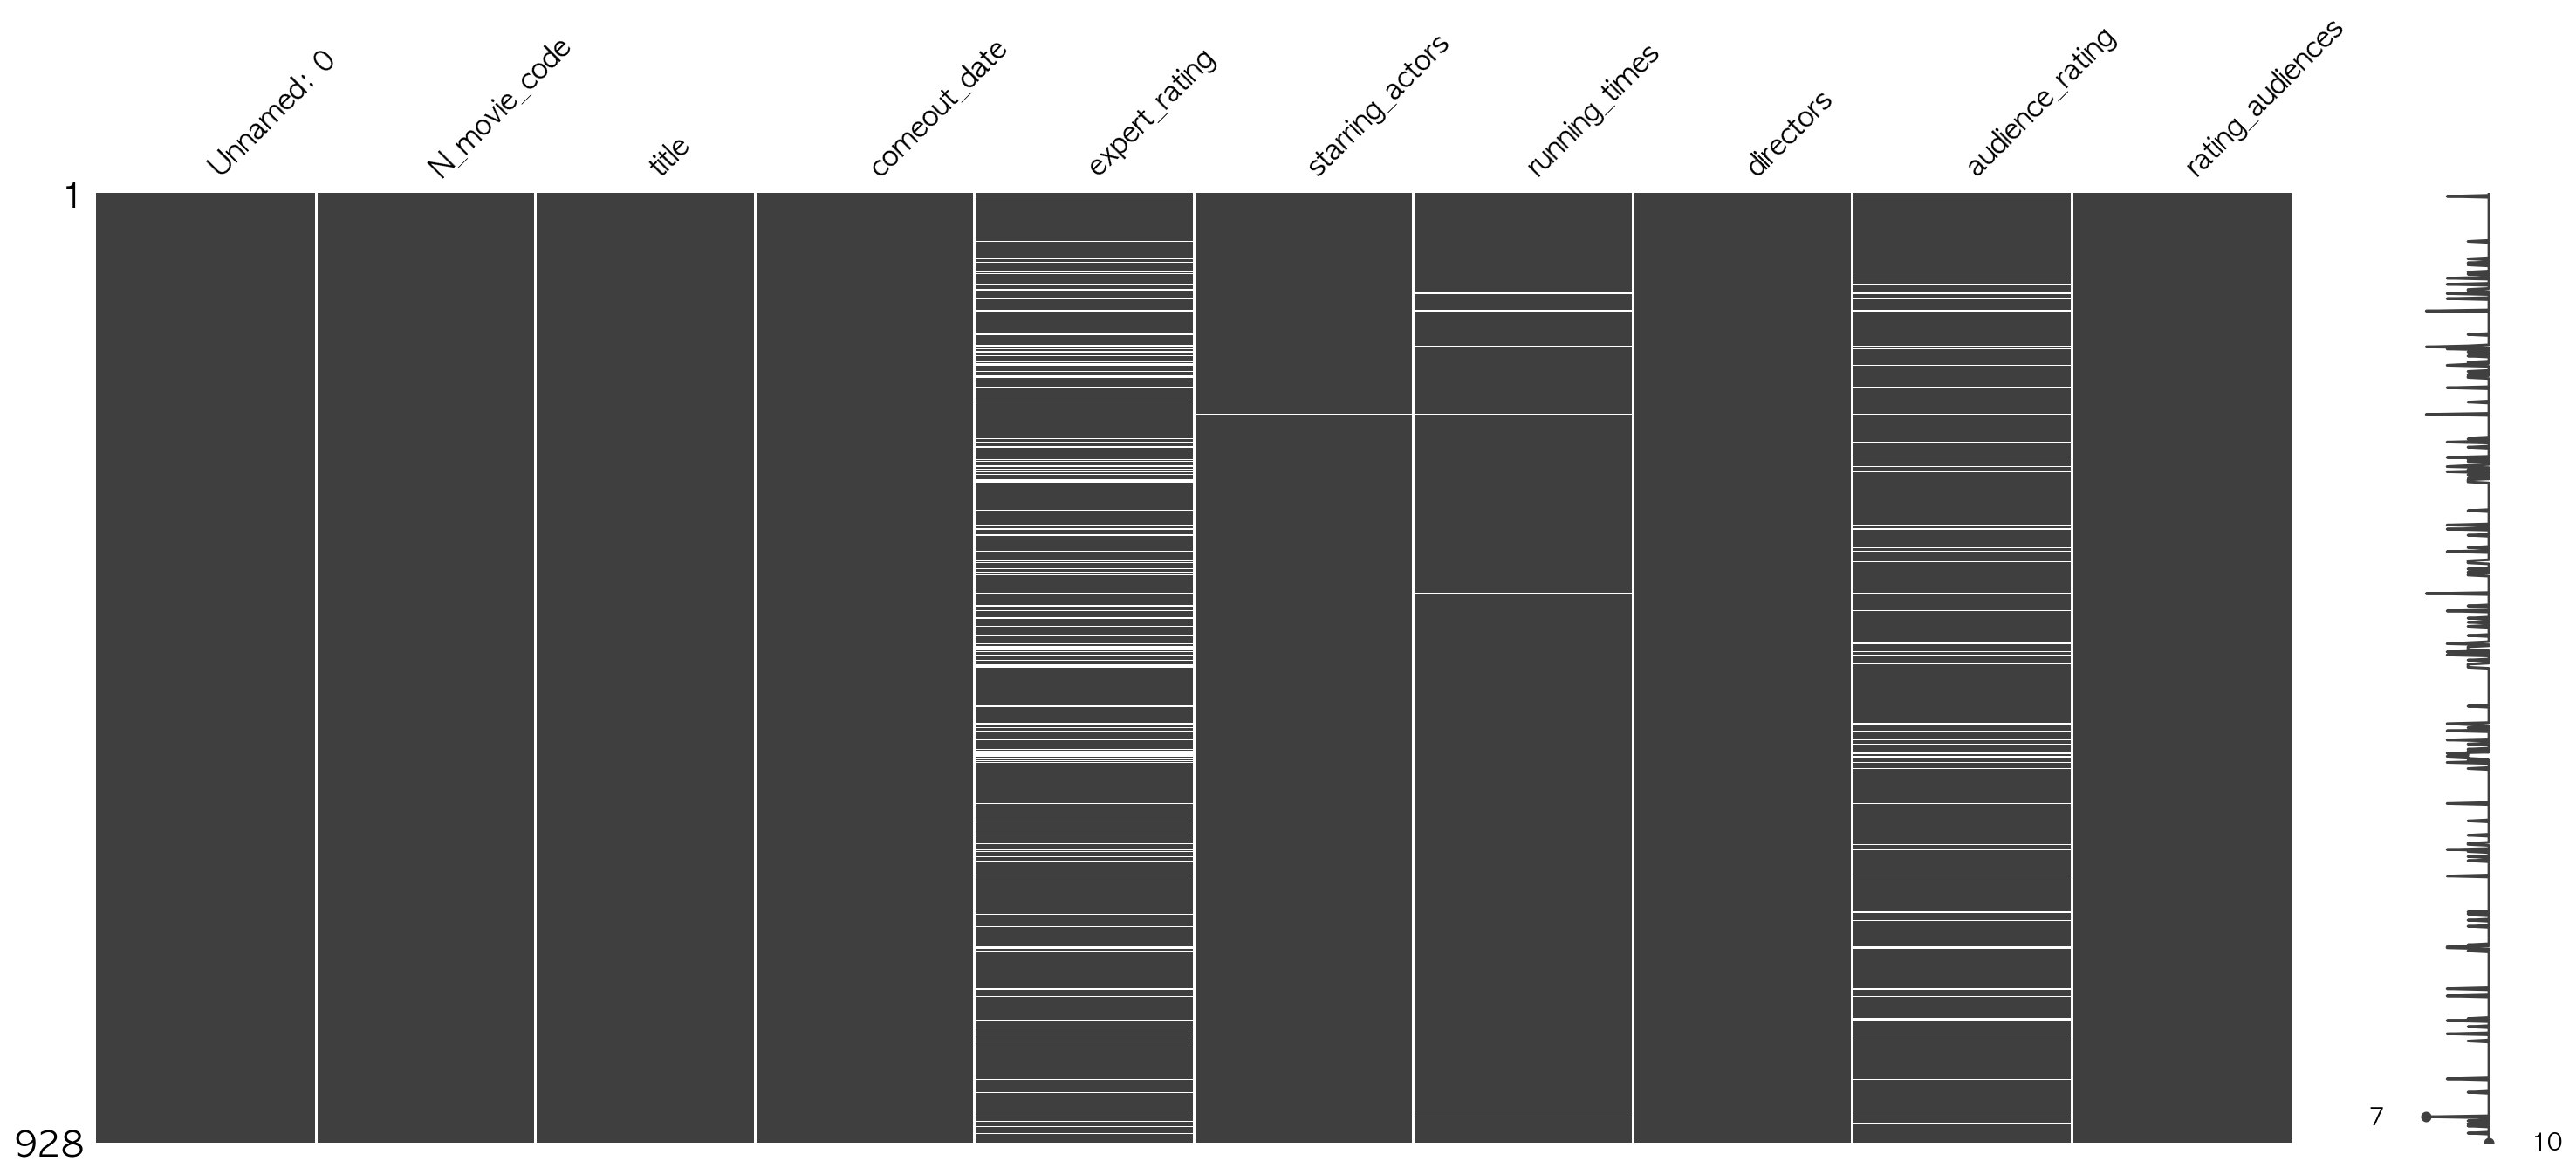

In [497]:
msn.matrix(a)
plt.show()

In [421]:
code = 191646
num = 99999
url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={}&type=after&onlyActualPointYn=Y&onlySpoilerPointYn=N&order=newest&page={}'.format(code, num)
req = requests.get(url)
response = TextResponse(req.url, body=req.text, encoding="utf-8")
number_list = response.xpath('/html/body/div/div/div[6]/div/a/span/text()').extract()
last_number = number_list[len(number_list) - 1]

cur_page = int(last_number.replace(',', ''))
cur_page



IndexError: list index out of range

In [415]:
# start_date = response.xpath('/html/body/div/div/div[5]/ul/li[5]/div[2]/dl/dt/em[2]/text()').extract()
# start_date = start_date[0].split(" ")[0].split('.')
# start_date


In [416]:
time_elements = response.xpath('/html/body/div/div/div[5]/ul/li/div/dl/dt/em[2]/text()')
start_date = time_elements[len(time_elements) - 1].extract().split(' ')[0]
start_date = start_date.split(" ")[0].split('.')
start_date

['2014', '12', '17']

In [417]:
len(time_elements)

2

In [395]:
cur_date = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[2]/dl/dt/em[2]/text()'.format(5)).extract()[0].split(' ')[0].split('.')
cur_date


['2015', '04', '23']

In [390]:
rating_elements = response.xpath('/html/body/div/div/div[5]/ul/li[{}]/div[1]/em/text()'.format(5)).extract()[0]
int(rating_elements)

8

In [278]:
int(start_date[1])

4

In [281]:
limit_date = datetime.datetime(int(start_date[0]), int(start_date[1]), int(start_date[2])) + datetime.timedelta(weeks=1)
limit_date

datetime.datetime(2015, 4, 30, 0, 0)

In [302]:
check_limit = limit_date - datetime.datetime(2015, 5, 1)

In [304]:
check_limit.days < 0 

True

In [ ]:
# !scrapy startproject crawler

In [ ]:
# %%writefile crawler/crawler/items.py
# import scrapy


# class CrawlerItem(scrapy.Item):
#     expert_rating = scrapy.Field()
#     starring_actors = scrapy.Field()
#     running_time = scrapy.Field()
#     director = scrapy.Field()
    

In [ ]:
# %%writefile crawler/crawler/spiders/spider.py
# import scrapy

# from crawler.items import CrawlerItem

# class Spider(scrapy.Spider):
#     name = "MovieSpider"
#     allow_domain = ["movie.naver.com"]
#     start_urls = []
    
#     def parse(self, response):
#         total_df = pd.read_csv('code_added_df.csv').drop(columns=['Unnamed: 0'])
#         code_list = list(total_df['N_movie_code'])
        
#         for code in code_list:
#             url = 'https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'.format(int(code))
#             yield scrapy.Request(url, callback=self.get_content)
            
#     def get_content(self, response):
#         item = CrawlerItem()
        
#         rate_number = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/div[1]/div[2]/div/a/div/em/text()').extract()
#         item['expert_rating'] = "".join(rate_number)
        
#         running_time = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[1]/p/span[3]/text()').extract()[0]
#         item['running_time'] = running_time
        
#         starring_actors = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[3]/p/a/text()').extract()
#         item['starring_actors'] = ", ".join(starring_actors)
        
#         director = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[2]/p/a/text()').extract()[0]
#         item['director'] = director
        
#         yield item
    

In [ ]:
# %%writefile run.sh
# cd crawler
# scrapy crawl GmarketSpider -o items.csv

In [ ]:
# 실행가능하도록 권한 바꾸기
# import os

# os.chmod("run.sh", 0o764)

In [ ]:
# 5. settings.py 수정
# !head -n 22 cat naver_article/naver_article/settings.py | tail -n 2

In [ ]:
# !sed -i 's/ROBOTSTXT_OBEY = True/ROBOTSTXT_OBEY = False/' naver_article/naver_article/settings.py

In [ ]:
# !head -n 22 cat naver_article/naver_article/settings.py | tail -n 2

In [ ]:
# !./run.sh

In [ ]:
# csv파일로 저장된 데이터 확인

# items_df = pd.read_csv("naver_article/items.csv")
# items_df.tail()

In [184]:
df2 = pd.read_csv('code_added_df.csv').drop(columns=['Unnamed: 0'])
N_movie_code = list(df2['N_movie_code'])
len(N_movie_code)

928

In [188]:
from scrapy.http import TextResponse

In [209]:
url = 'https://movie.naver.com/movie/bi/mi/basic.nhn?code={}'.format(67786)
req = requests.get(url)
response = TextResponse(req.url, body=req.text, encoding="utf-8")

a = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[2]/p/a/text()').extract()[0]
a

'콜린 트레보로우'